In [1]:
import chirpy_mk1

In [101]:
from chirpy_mk1.utils import G_Newt, c_ls, MSUN_SI, MTSUN_SI, MRSUN_SI, PC_SI, GAMMA, Msun_to_sec
from chirpy_mk1.ansatz import PSF_freq_ins, PSF_freq_int, PSF_freq_mrd
from chirpy_mk1.ansatz import PSF_amp_ins, PSF_amp_int, PSF_amp_mrd
from chirpy_mk1.ansatz import amp_ins_ansatz, amp_int_ansatz, amp_mrd_ansatz
from chirpy_mk1.ansatz import freq_ins_ansatz, freq_int_ansatz, freq_mrd_ansatz
from chirpy_mk1.ansatz import analytic_phase_ins_ansatz, analytic_phase_int_ansatz
from chirpy_mk1.ansatz import analytic_phase_mrd_ansatz

from chirpy_mk1.ansatz import analytic_phase_mrd_ansatz_approx

import numpy as np
from scipy import optimize
import phenom

In [18]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16}) 

In [49]:
def setup_ins_coeffs(eta):
    freq_inc_tc = PSF_freq_ins('tc',eta)
    freq_inc_b = PSF_freq_ins('b',eta)
    freq_inc_c = PSF_freq_ins('c',eta)

    # amp
    params_amp_ins={}
    params_amp_ins.update({
        'a0': np.float64(PSF_amp_ins('a0', eta)),
        'a1': np.float64(PSF_amp_ins('a1', eta))
    })

    # amplitude ins model depends on freq ins model
    params_amp_ins.update({
        'tc':np.float64(freq_inc_tc),
        'b':np.float64(freq_inc_b),
        'c':np.float64(freq_inc_c)
    })
    
    return params_amp_ins

In [52]:
def mk1_amp_ins(times, eta, params_amp_ins):
    return amp_ins_ansatz(times, eta, params_amp_ins)

In [229]:
# times = np.linspace(-1000, -500, 100000)
times = np.arange(-1000, -500, 1./2048/4)
eta = np.float64(0.25)
params_amp_ins = setup_ins_coeffs(eta)

In [230]:
%timeit mk1_amp_ins(times, eta, params_amp_ins)

939 ms ± 14.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [231]:
amp = mk1_amp_ins(times, eta, params_amp_ins)

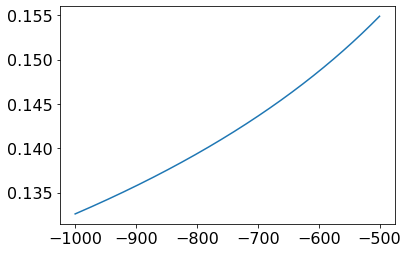

In [224]:
plt.figure()
plt.plot(times, amp)

# explicit amp ins function

In [57]:
from chirpy_mk1.pn import TaylorT3_Omega_new, Hhat22_x

In [102]:
import math

In [109]:
def explicit_TaylorT3_Omega_new(t, tc, eta, M):

    Msec = Msun_to_sec(M)
    Msec = M

    pi2 = math.pi*math.pi

    c1 = eta/(5.*Msec)

    td = c1 * (tc - t)

#     td = np.sqrt(td**2 + 1)

    theta = td**(-1./8.) # -1./8. = -0.125

    theta2 = theta*theta
    theta3 = theta2*theta
    theta4 = theta3*theta
    theta5 = theta4*theta
    theta6 = theta5*theta
    theta7 = theta6*theta

    # pre factor
    ftaN = 1. / ( 8. * math.pi * Msec  )
    # 0PN
    fts1 = 1.
    # 0.5PN = 0 in GR
    # 1PN
    fta2 = 7.43/26.88 + 1.1/3.2 * eta
    # 1.5PN
    fta3 = -3./10. * math.pi
    # 2PN
    fta4 = 1.855099/14.450688 + 5.6975/25.8048 * eta + 3.71/20.48 * eta*eta
    # 2.5PN
    fta5 = (-7.729/21.504 + 1.3/25.6 * eta) * math.pi
    # 3PN
    fta6 = -7.20817631400877/2.88412611379200 + 5.3/20.0 * pi2 + 1.07/2.80 * GAMMA  \
           + (25.302017977/4.161798144 - 4.51/20.48 * pi2) * eta \
           - 3.0913/183.5008 * eta*eta + 2.35925/17.69472 * eta*eta*eta

    # 3.5PN
    fta7 = (-1.88516689/4.33520640 - 9.7765/25.8048 * eta + 1.41769/12.90240 * eta*eta) * math.pi

    # 3PN log term
    ftal6 = 1.07/2.80


    full = theta3*ftaN * (fts1 \
             + fta2*theta2 \
             + fta3*theta3 \
             + fta4*theta4 \
             + fta5*theta5 \
             + (fta6 + ftal6*math.log(2.*theta))*theta6 \
             + fta7*theta7)

    return full * 2 * math.pi # 2pi to go from freq to angular freq

In [114]:
def explicit_freq_ins_ansatz(t, eta, tc, b, c):
    """
    this is the frequency inspiral ansatz.
    I needed an separate function so that I could use it in the amplitude inspiral model
    """

#     tc = params['tc']
#     b = params['b']
#     c = params['c']
    M = 1

    tau = eta * (tc - t) / (5*M)
    
    t3 = np.array([explicit_TaylorT3_Omega_new(tt, tc, eta, M) for tt in t])
    
    model = (t3 + b*tau**(-9./8.) + c*tau**(-10./8.))

    return model

In [115]:
def explicit_amp_ins_ansatz(t, eta, tc, a0, a1, b, c):
    tau = (tc-t)
    
    GW22AngFreq = explicit_freq_ins_ansatz(t, eta, tc, b, c)
    OrgAngFreq = GW22AngFreq / 2.

    M = 1
    x = (M*OrgAngFreq)**(2./3)

    T3amp = np.abs( Hhat22_x(x, eta) )

    model = T3amp + a0*tau**(-9./8.) + a1*tau**(-10./8.)

    return model

In [116]:
tc = params_amp_ins['tc']
a0 = params_amp_ins['a0']
a1 = params_amp_ins['a1']
b = params_amp_ins['b']
c = params_amp_ins['c']

In [117]:
%timeit explicit_amp_ins_ansatz(times, eta, tc, a0, a1, b, c)

55.9 ms ± 859 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [118]:
numba_amp = explicit_amp_ins_ansatz(times, eta, tc, a0, a1, b, c)

In [63]:
from numba import vectorize

In [64]:
type(eta)

numpy.float64

In [65]:
type(c)

numpy.float64

In [75]:
@vectorize(['int64(int64, int64)']) # Type signature and target are required for the GPU
def add_ufunc(x, y):
    return x + y

In [76]:
a = np.array([1, 2, 3, 4])
b = np.array([10, 20, 30, 40])

In [77]:
add_ufunc(a,b)

array([11, 22, 33, 44])

In [79]:
add_ufunc(4,b)

array([14, 24, 34, 44])

In [122]:
from numba import jit, njit

In [123]:
# @vectorize(['float64(float64,float64,float64,float64,float64,float64,float64)'])
@njit
def numba_vec_amp_ins_ansatz(t, eta, tc, a0, a1, b, c):
    tau = (tc-t)
    
    GW22AngFreq = explicit_freq_ins_ansatz(t, eta, tc, b, c)
#     GW22AngFreq = np.ones(len(t))
    OrgAngFreq = GW22AngFreq / 2.

    M = 1
    x = (M*OrgAngFreq)**(2./3)

#     T3amp = np.abs( Hhat22_x(x, eta) )
    T3amp = np.ones(len(t))

    model = T3amp + a0*tau**(-9./8.) + a1*tau**(-10./8.)

    return model

In [124]:
numba_vec_amp_ins_ansatz(times, eta, tc, a0, a1, b, c)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Untyped global name 'explicit_freq_ins_ansatz': cannot determine Numba type of <class 'function'>

File "<ipython-input-123-cef1879e672a>", line 6:
def numba_vec_amp_ins_ansatz(t, eta, tc, a0, a1, b, c):
    <source elided>
    
    GW22AngFreq = explicit_freq_ins_ansatz(t, eta, tc, b, c)
    ^

This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/latest/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/latest/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new


In [90]:
%timeit numba_vec_amp_ins_ansatz(times, eta, tc, a0, a1, b, c)

396 µs ± 10.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# jit omega pn ins?

In [167]:
# @njit
# @njit(['float64[:](float64[:],float64,float64,float64)'])
@vectorize(['float64(float64,float64,float64,float64)'])
def numba_vec_TaylorT3_Omega_new(t, tc, eta, M):

#     Msec = Msun_to_sec(M)
    Msec = M

    pi2 = math.pi*math.pi

    c1 = eta/(5.*Msec)

    td = c1 * (tc - t)

#     td = np.sqrt(td**2 + 1)

    theta = td**(-1./8.) # -1./8. = -0.125

    theta2 = theta*theta
    theta3 = theta2*theta
    theta4 = theta3*theta
    theta5 = theta4*theta
    theta6 = theta5*theta
    theta7 = theta6*theta

    # pre factor
    ftaN = 1. / ( 8. * math.pi * Msec  )
    # 0PN
    fts1 = 1.
    # 0.5PN = 0 in GR
    # 1PN
    fta2 = 7.43/26.88 + 1.1/3.2 * eta
    # 1.5PN
    fta3 = -3./10. * math.pi
    # 2PN
    fta4 = 1.855099/14.450688 + 5.6975/25.8048 * eta + 3.71/20.48 * eta*eta
    # 2.5PN
    fta5 = (-7.729/21.504 + 1.3/25.6 * eta) * math.pi
    # 3PN
    fta6 = -7.20817631400877/2.88412611379200 + 5.3/20.0 * pi2 + 1.07/2.80 * GAMMA  \
           + (25.302017977/4.161798144 - 4.51/20.48 * pi2) * eta \
           - 3.0913/183.5008 * eta*eta + 2.35925/17.69472 * eta*eta*eta

    # 3.5PN
    fta7 = (-1.88516689/4.33520640 - 9.7765/25.8048 * eta + 1.41769/12.90240 * eta*eta) * math.pi

    # 3PN log term
    ftal6 = 1.07/2.80


    full = theta3*ftaN * (fts1 \
             + fta2*theta2 \
             + fta3*theta3 \
             + fta4*theta4 \
             + fta5*theta5 \
             + (fta6 + ftal6*math.log(2.*theta))*theta6 \
             + fta7*theta7)

    return full * 2 * math.pi # 2pi to go from freq to angular freq

In [169]:
numba_vec_TaylorT3_Omega_new(times[0], tc, eta, np.float64(1))

0.03564714965219574

In [170]:
list(map(type,[times, tc, eta, np.float64(1)]))

[numpy.ndarray, numpy.float64, numpy.float64, numpy.float64]

In [254]:
%timeit numba_vec_TaylorT3_Omega_new(times, tc, eta, np.float64(1))

4.24 ms ± 140 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [255]:
nt3 = numba_vec_TaylorT3_Omega_new(times, tc, eta, np.float64(1))

In [256]:
%timeit TaylorT3_Omega_new(times, tc, eta, 1)

3.38 ms ± 224 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [257]:
t3 = TaylorT3_Omega_new(times, tc, eta, 1)

In [258]:
np.testing.assert_array_almost_equal(t3, nt3)

In [176]:
@vectorize(['float64(float64,float64,float64,float64,float64)'])
def numba_vec_freq_ins_ansatz(t, eta, tc, b, c):
#     tc = params['tc']
#     b = params['b']
#     c = params['c']
    M = 1

    tau = eta * (tc - t) / (5*M)
    
    t3 = numba_vec_TaylorT3_Omega_new(t, tc, eta, np.float64(1))
#     t3 = np.array([explicit_TaylorT3_Omega_new(tt, tc, eta, M) for tt in t])
    
    model = (t3 + b*tau**(-9./8.) + c*tau**(-10./8.))

    return model

In [179]:
%timeit numba_vec_freq_ins_ansatz(times, eta, tc, b, c)

737 µs ± 17.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [183]:
%timeit freq_ins_ansatz(times, eta, {'tc':tc, 'b':b, 'c':c})

662 µs ± 9.31 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [185]:
aa1 = freq_ins_ansatz(times, eta, {'tc':tc, 'b':b, 'c':c})
aa2 = numba_vec_freq_ins_ansatz(times, eta, tc, b, c)

In [186]:
np.testing.assert_array_almost_equal(aa1, aa2)

In [200]:
@vectorize(['float64(float64,float64)'])
def numba_vec_Hhat22_x(x, eta):

#     xarr = np.zeros(6, dtype=np.complex128)
    xarr = [0+1.j, 0+1.j, 0+1.j, 0+1.j, 0+1.j, 0+1.j]

    C = 0.577216 # is the Euler constant

    xarr[0] = 1.
    xarr[1] = -107./42 + 55*eta/42
    xarr[2] = 2.*math.pi
    xarr[3] = -2173./1512 - 1069.*eta/216 + 2047.*eta**2/1512
    xarr[4] = (-107*math.pi/21 - 24.*1.j*eta + 34.*math.pi*eta/21) # there is an i... not sure what to do...

    x5a = 27027409./646800 - 856.*C/105 + 428*1.j*math.pi/105 + 2.*math.pi**2/3
    x5b = (-278185./33264 + 41*math.pi**2/96)*eta - 20261.*eta**2/2772 + 114635.*eta**3/99792

    x5log =  - 428.*math.log(16*x)/105

    xarr[5] = (x5a) + x5b # there is an i...  not sure what to do...

    pre = math.sqrt(16.*math.pi/5) * 2 * eta

    pn = xarr[0] + x*xarr[1] + x**(3/2.)*xarr[2] + x**2*xarr[3] + x**(5/2.)*xarr[4] + x**3*(xarr[5] + x5log)

    return pre * abs(pn) * x

In [266]:
@vectorize(['float64(float64,float64,float64,float64,float64,float64,float64)'])
def numba_vec_amp_ins_ansatz(t, eta, tc, a0, a1, b, c):
    tau = (tc-t)
    
    GW22AngFreq = numba_vec_freq_ins_ansatz(t, eta, tc, b, c)
    OrgAngFreq = GW22AngFreq / 2.

    M = 1
    x = (M*OrgAngFreq)**(2./3)

#     T3amp = abs( numba_vec_Hhat22_x(x, eta) )
    T3amp = numba_vec_Hhat22_x(x, eta)

    model = T3amp + a0*tau**(-9./8.) + a1*tau**(-10./8.)

    return model

In [232]:
%timeit numba_vec_amp_ins_ansatz(times, eta, tc, a0, a1, b, c)

1.6 s ± 14.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [233]:
amp_numba_vec = numba_vec_amp_ins_ansatz(times, eta, tc, a0, a1, b, c)

In [234]:
%timeit mk1_amp_ins(times, eta, params_amp_ins)

916 ms ± 4.04 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [235]:
amp = mk1_amp_ins(times, eta, params_amp_ins)

In [236]:
np.testing.assert_array_almost_equal(amp_numba_vec, amp)

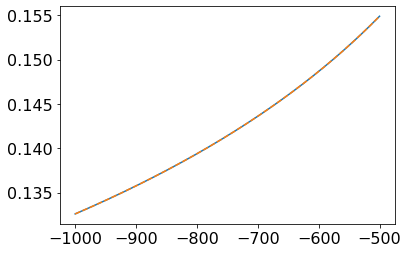

In [237]:
plt.figure()
plt.plot(times, amp)
plt.plot(times, amp_numba_vec, ls='--')